In [46]:
import pandas as pd
import numpy as np
from random import shuffle
from numpy.linalg import inv
import matplotlib.pyplot as plt
from math import floor, log
import os

train_path = "./data/train.csv"
test_path = "./data/test.csv"

In [47]:
attr = ["age", "workclass", "fnlwgt", "education", "education-num",\
       "marital-status", "occupation", "relationship", "race", "sex",\
       "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
con_attr = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
bool_attr = ["sex"]
cat_attr = list(set(attr) - set(con_attr) - set(bool_attr))

In [48]:
train_raw_data = pd.read_csv(train_path, sep=",", names=attr)
test_raw_data = pd.read_csv(test_path, sep=",", names=attr)

In [49]:
# 数据预处理
def dataProcess_X(rawData):
    # income不在该函数处理
    # sex由于只有两个属性，可以视作bool型0-1变量
    if "income" in rawData.columns:
        Data = rawData.drop(["sex", 'income'], axis=1)
    else:
        Data = rawData.drop(["sex"], axis=1)
    # 读取非连续型数据
    listObjectColumn = [col for col in Data.columns if Data[col].dtypes == "object"]
    # 读取连续型数据
    listNonObjedtColumn = [x for x in list(Data) if x not in listObjectColumn]
    
    ObjectData = Data[listObjectColumn]
    NonObjectData = Data[listNonObjedtColumn]
    
    # 对连续型数据normalize 标准化
    NonObjectData = (NonObjectData - NonObjectData.mean()) / NonObjectData.std()
    
    # 讲sex数据插入
    NonObjectData.insert(0 ,"sex", (rawData["sex"] == " Female").astype(np.int))
    # one-hot编码 将非连续数据中的“？”作为一个独立的属性
    ObjectData = pd.get_dummies(ObjectData)
    # 合并
    Data = pd.concat([NonObjectData, ObjectData], axis=1)

    return Data

def dataProcess_Y(rawData):
    df_y = rawData['income']
    Data_y = pd.DataFrame((df_y==' >50K').astype("int64"), columns=["income"])
    return Data_y

In [50]:
def sigmoid(z):
    res = 1 / (1.0 + np.exp(-z))
    return np.clip(res, 1e-8, (1-(1e-8)))

# X and Y are np.array
def _shuffle(X, Y):
    randomize = np.arange(X.shape[0])
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def split_valid_set(X, Y, percentage):
    all_size = X.shape[0]
    valid_size = int(floor(all_size * percentage))

    X, Y = _shuffle(X, Y)
    X_valid, Y_valid = X[: valid_size], Y[: valid_size]
    X_train, Y_train = X[valid_size :], Y[valid_size :]

    return X_train, Y_train, X_valid, Y_valid

def valid(X, Y, w):
    a = np.dot(X, w)
    y = sigmoid(a)
    y_ = np.around(y)
    result = np.sum(Y == y_)
    print('logistic regression model 准确率 = %f' % (result / len(Y)))
    return y_

def train(X_train, Y_train, reg):

    w = np.zeros((len(X_train[0]), 1))

    l_rate = 0.001
    batch_size = 32
    train_dataz_size = len(X_train)
    step_num = int(floor(train_dataz_size / batch_size))
    epoch_num = 300
    list_cost = []

    total_loss = 0.0
    for epoch in range(1, epoch_num):
        total_loss = 0.0
        X_train, Y_train = _shuffle(X_train, Y_train)
        
        # SGD 随机梯度下降
        for idx in range(1, step_num):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]

#             s_grad = np.zeros(len(X[0]))

            z = np.dot(X, w)
            y = sigmoid(z)
            loss = y - Y
            cross_entropy = reg * np.dot(w.T, w).item() / 2 / len(Y) - (np.dot(Y.T, np.log(y)) + np.dot((-Y + 1).T, np.log(1 - y)))/ len(Y)
            total_loss += cross_entropy.item()
            grad = np.dot(X.T, y - Y) / len(Y) + reg * w / len(Y)
            # grad = np.dot(X.T, loss)
            w = w - l_rate * grad

            # s_grad += grad ** 2
            # ada = np.sqrt(s_grad)
            # w = w - l_rate * grad / ada

        list_cost.append(total_loss)

    plt.plot(np.arange(len(list_cost)), list_cost)
    plt.title("Train Process")
    plt.xlabel("epoch_num")
    plt.ylabel("Cost Function (Cross Entropy)")
    plt.show()

    return w

In [51]:
x_train = dataProcess_X(train_raw_data).drop(['native-country_ Holand-Netherlands'], axis=1).values
x_test = dataProcess_X(test_raw_data).values
y_train = dataProcess_Y(train_raw_data).values
y_test = dataProcess_Y(test_raw_data).values

In [54]:
# 增加偏置项bias
x_test_bias = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)
x_train_bias = np.concatenate((np.ones((x_train.shape[0], 1)),x_train), axis=1)
valid_set_percentage = 0.1
X_train, Y_train, X_valid, Y_valid = split_valid_set(x_train_bias, y_train, valid_set_percentage) 

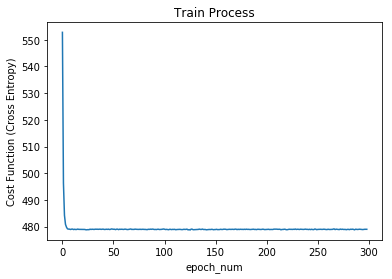

在训练集的验证集上验证结果：
logistic regression model 准确率 = 0.791155


In [68]:
# 训练
w_train = train(X_train, Y_train, reg = 10)
# 验证
print("在训练集的验证集上验证结果：")
_ = valid(X_valid, Y_valid, w_train)

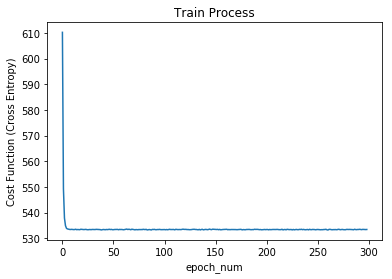

在测试集上验证结果：
logistic regression model 准确率 = 0.805049


In [69]:
# 训练
w_train = train(x_train_bias, y_train, reg = 10)
# 预测
print("在测试集上验证结果：")
_ = valid(x_test_bias, y_test, w_train)

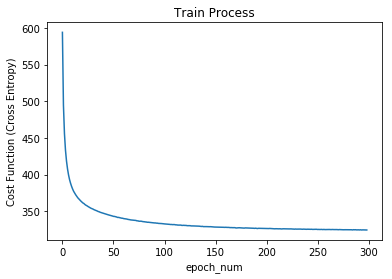

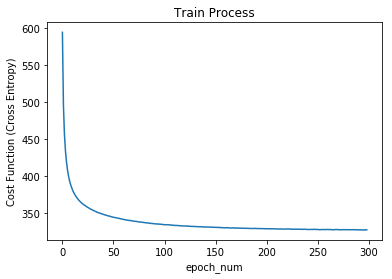

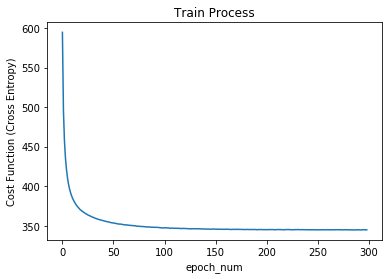

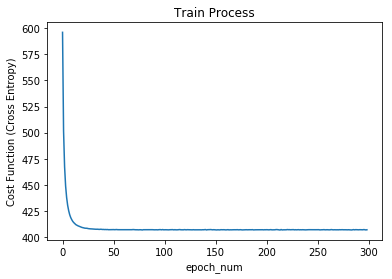

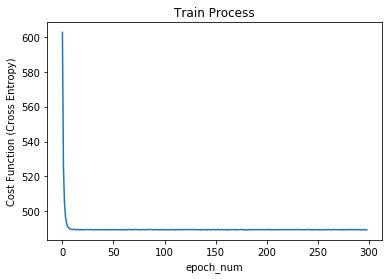

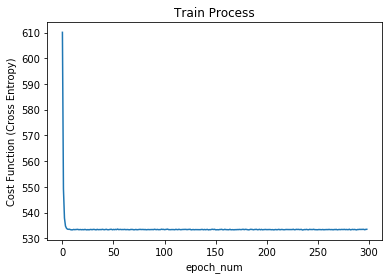

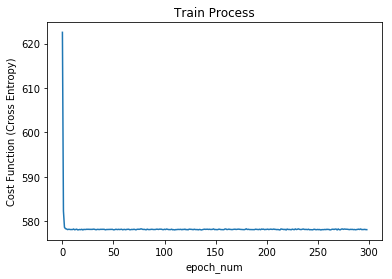

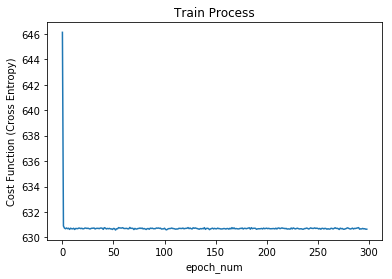

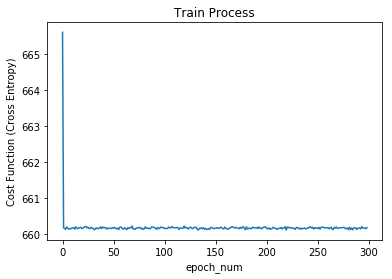

In [70]:
regs = [0.0001, 0.01, 0.1, 1, 5, 10, 20, 50, 100]
acc = []
for reg in regs:
    w_train = train(x_train_bias, y_train, reg)
    a = np.dot(x_test_bias, w_train)
    y_ = sigmoid(a)
    y_ = np.around(y_)
    result = np.sum(y_test == y_)
    acc.append(result / len(y_test))

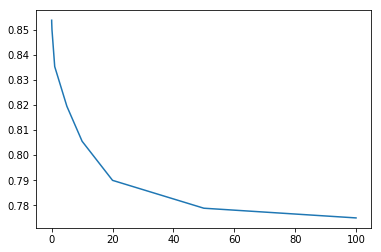

In [71]:
plt.figure(1)
plt.plot(regs, acc)
plt.show()